In [1]:
import math
from functools import partial
from time import time

from scipy.optimize import basinhopping, shgo, minimize_scalar, direct, dual_annealing
from scipy.interpolate import splprep
import cadquery as cq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# %matplotlib inline

import splinecloud_scipy as sc

In [2]:
# profile_data = sc.LoadSubset("sbt_XcZUwUj5CuZf")
# profile_data = sc.LoadSubset("sbt_tnZbUHv0uTGO")
# profile_data = sc.LoadSubset("sbt_38mLwhFXLXlD")
# profile_data = sc.LoadSubset("sbt_oll9JwctqjUx")
# profile_data = sc.LoadSubset("sbt_S0woIPGIlbwm")
profile_data = sc.LoadSubset("sbt_AfnajnXWA7nj") ## NACA 63-210
# profile_data = sc.LoadSubset("sbt_J8zx2Nw8qLo8")

In [3]:
airfoil_profile_points = profile_data.values.tolist()

## Build Profile Curve

In [4]:
def bspl_approx_profile(profile_points, s=1e-5, k=3):
    """
    B-Spline approximation of the discrete profile data, represented in Selig format
    
    Paameters:
    'pp' - array of [x,y] coords
    's' - smoothing factor
    'k' - spline degree
    
    Returns:
    'bspl' - B-Spline represntation, instances of the SplineCloud ParametricUnivariateSpline
    """
    xvals = [p[0] for p in profile_points]
    yvals = [p[1] for p in profile_points]
    
    ## set weights to critical profile points
    weight_mod = lambda x: 20 if x==0.0 else (5 if x==1.0 else 1)
    weights = list(map(weight_mod, xvals))
    
    tck, u = splprep([xvals, yvals], s=s, k=k, w=weights)
    t, c, k = tck
    cx, cy = c
    
    print(len(cx))
    
    ## adjust spline end points to match profile points
    cx[0], cy[0] = profile_points[0]
    cx[-1], cy[-1] = profile_points[-1]

    bspl = sc.ParametricUnivariateSpline.from_tcck([t, cx, cy, k])
    
    return bspl

### Find B-Spline fit

In [5]:
bspl = bspl_approx_profile(airfoil_profile_points)

13


In [6]:
## evaluate spline points with high resulution
spline_knotspace = np.linspace(0, 1, 600)
spline_points = [bspl(k) for k in spline_knotspace]

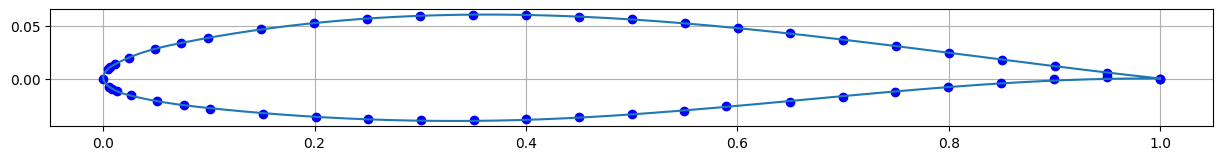

In [7]:
## plot results
spl_x, spl_y = zip(*spline_points)
px, py = zip(*airfoil_profile_points)

plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(px, py, 'bo')
plt.plot(spl_x, spl_y)
plt.grid()
# plt.xlim(-0.1, 0.2) ## zoom nose tip
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.show()

## Evaluate fit tolerance

In [8]:
def dist(t, bspl, point):
    ## computes distance between point on bspl curve at given parameter t and cartesian point
    sx, sy = bspl(t)
    px, py = point
    dist = math.sqrt((px-sx)**2 + (py-sy)**2)
    
    return dist

In [9]:
def find_min_dist_scalar(bspl, data_point):
    ## find minimal distance between data_point and B-Spline curve using local minimzation algorithm
    f = partial(dist, bspl=bspl, point=data_point)
    res = minimize_scalar(f, bounds=[0.0, 1.0], method="bounded")
    d = dist(res.x, bspl, data_point)
    
    return d

In [10]:
# find_min_dist_scalar(bspl, airfoil_profile_points[30])

In [11]:
def find_min_dist_shgo(bspl, data_point):
    ## find minimal distance between data_point and B-Spline curve using global minimzation algorithm
    f = partial(dist, bspl=bspl, point=data_point)
    res = shgo(f, bounds=[(0.0, 1.0)])
    d = dist(res.x[0], bspl, data_point)
    
    return d

In [12]:
# find_min_dist_shgo(bspl, airfoil_profile_points[30])

In [13]:
def find_min_dist_basinhopping(bspl, data_point):
    ## find minimal distance between data_point and B-Spline curve using global minimzation algorithm
    def f(t):
        if t > 1.0:
            return 1e6
        elif t < 0.0:
            return 1e6
        
        return dist(t, bspl, data_point)
        
    res = basinhopping(f, 0.5, minimizer_kwargs={"method": "BFGS"})
    d = dist(float(res.x), bspl, data_point)
    
    return d

In [14]:
# find_min_dist_basinhopping(bspl, airfoil_profile_points[20])

In [15]:
def find_min_dist_direct(bspl, data_point):
    ## find minimal distance between data_point and B-Spline curve using global minimzation algorithm
    f = partial(dist, bspl=bspl, point=data_point)
    res = direct(f, bounds=[(0.0, 1.0)])
    d = dist(res.x[0], bspl, data_point)
    
    return d

In [16]:
# find_min_dist_direct(bspl, airfoil_profile_points[20])

### Calculate errors with different methods

In [17]:
t = time()
appox_errors_local = [find_min_dist_scalar(bspl, p) for p in airfoil_profile_points]
print("time:", time() - t)

time: 0.01222848892211914


In [18]:
t = time()
appox_errors_shgo = [find_min_dist_shgo(bspl, p) for p in airfoil_profile_points]
print("time:", time() - t)

time: 0.15997624397277832


In [19]:
t = time()
appox_errors_basinhopping = [find_min_dist_basinhopping(bspl, p) for p in airfoil_profile_points]
print("time:", time() - t)

time: 8.648877143859863


In [20]:
t = time()
appox_errors_direct = [find_min_dist_direct(bspl, p) for p in airfoil_profile_points]
print("time:", time() - t)

time: 0.06687736511230469


In [21]:
errors_stack = np.dstack([appox_errors_local, appox_errors_shgo, appox_errors_basinhopping, appox_errors_direct])

In [22]:
errors_stack[0]

array([[1.20470963e-05, 0.00000000e+00, 7.54517494e-03, 6.35195852e-07],
       [3.55795522e-04, 3.55785629e-04, 3.55785628e-04, 3.55785628e-04],
       [4.12158572e-04, 4.12157037e-04, 4.12157037e-04, 4.12157507e-04],
       [3.77404809e-04, 3.77402347e-04, 3.77402347e-04, 3.77402421e-04],
       [2.22399924e-04, 2.22377607e-04, 2.22377606e-04, 2.22377810e-04],
       [6.35966518e-05, 6.35955152e-05, 6.35955129e-05, 6.35969835e-05],
       [7.27754805e-05, 7.27753126e-05, 7.27753110e-05, 7.27753169e-05],
       [1.52903668e-04, 1.52894155e-04, 1.52894154e-04, 1.52894222e-04],
       [1.77643170e-04, 1.77635680e-04, 1.77635680e-04, 1.77635709e-04],
       [1.50856371e-04, 1.50850960e-04, 1.50850959e-04, 1.50852034e-04],
       [1.05132376e-04, 1.05129521e-04, 1.05129521e-04, 1.05129525e-04],
       [2.12627976e-05, 2.11584006e-05, 2.11584006e-05, 2.11648560e-05],
       [7.16385730e-05, 7.16379362e-05, 7.16379359e-05, 7.16379427e-05],
       [1.55296514e-04, 1.55264840e-04, 1.55264840e

### Calculate mean approimation errors

In [23]:
mindist_methods = {
    "scalar": find_min_dist_scalar,
    "shgo": find_min_dist_shgo,
    "basinhopping": find_min_dist_basinhopping,
    "direct": find_min_dist_direct,
}

In [24]:
def find_approx_error(bspl, data_points, method="direct"):
    """
    Calculate mean absolute error or root-mean-square error 
    """
    abs_errors = []
    squared_errors = []
        
    if method not in mindist_methods.keys():
        raise ValueError("Unsupported method")
        
    dist_func = mindist_methods[method]
        
    for point in data_points:
        error = dist_func(bspl, point)
        abs_errors.append(error)
        squared_errors.append(error**2)
            
    mae = sum(abs_errors)/len(abs_errors)
    rmse = math.sqrt(sum(squared_errors)/len(squared_errors))
    
    return mae, rmse

In [25]:
mae_scalar, rmse_scalar = find_approx_error(bspl, airfoil_profile_points, method="scalar")
mae_scalar, rmse_scalar

(0.0005608228404520003, 0.001885126175866498)

In [26]:
mae_direct, rmse_direct = find_approx_error(bspl, airfoil_profile_points, method="direct")
mae_direct, rmse_direct

(0.00027864827595629004, 0.0003944303192911767)